In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "BBR-BPC"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn025821,MFAVDLPFELNVLGHNCDPLGMDGAQVGVLKQTHQLFLTVELQMDD...,357,1
1,Achn049331,MRVQTIQFTPITSGEAHRFAAILLKHASTGLGLLVFEAYFCSVSAF...,388,1
2,Achn053261,MAERDSAIREKNMALDERRRAFAERDMAMLQRDAAIAERNSAVEER...,288,1
3,Achn067521,MVEVICHGSYFDFIRCTSRWFGSLNSVTSCSKLFEVSESCESREIL...,323,1
4,Achn075701,MAERDAAIRERNAALDERRRAFAERDMAMLQRDMGIAERNTAIEER...,283,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
130,0.003012,0.003012,0.003012,0.003012,0.003012,0.018072,0.003012,0.003012,0.003012,0.000000,...,0.003012,0.003012,0.0,0.003012,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1443,0.004329,0.000000,0.000000,0.004329,0.000000,0.008658,0.012987,0.008658,0.012987,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1185,0.014663,0.000000,0.005865,0.011730,0.005865,0.000000,0.005865,0.017595,0.014663,0.002933,...,0.000000,0.002933,0.0,0.005865,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1118,0.003623,0.003623,0.000000,0.000000,0.007246,0.007246,0.003623,0.000000,0.003623,0.003623,...,0.003623,0.007246,0.0,0.003623,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1902,0.006565,0.000000,0.000000,0.000000,0.000000,0.006565,0.000000,0.002188,0.002188,0.006565,...,0.002188,0.000000,0.0,0.000000,0.004376,0.002188,0.006565,0.002188,0.002188,0.0


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1989, 439)
X_test: (498, 439)
y_train: (1989,)
y_test: (498,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         112,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 155,905 (609.00 KB)

 Trainable params: 155,905 (609.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 11s 480ms/step - accuracy: 0.5312 - loss: 0.6930

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6417 - loss: 0.6819 - val_accuracy: 0.9749 - val_loss: 0.5631


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.5882

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9461 - loss: 0.4539 - val_accuracy: 0.9874 - val_loss: 0.0825


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0648

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0593 - val_accuracy: 0.9899 - val_loss: 0.0246


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0890

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0231 - val_accuracy: 0.9925 - val_loss: 0.0150


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0210

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9919 - loss: 0.0234 - val_accuracy: 0.9975 - val_loss: 0.0103


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0360

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0137 - val_accuracy: 0.9925 - val_loss: 0.0155


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0016

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0089 - val_accuracy: 0.9950 - val_loss: 0.0137


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0028

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9975 - val_loss: 0.0126


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0142

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0150 - val_accuracy: 0.9925 - val_loss: 0.0295


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0102

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0067 - val_accuracy: 0.9975 - val_loss: 0.0080


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.4057e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9975 - val_loss: 0.0080


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.2888e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9975 - val_loss: 0.0084


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5295e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 1.0000 - loss: 6.8190e-04 - val_accuracy: 0.9975 - val_loss: 0.0071


Epoch 14/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4309e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 9.1615e-04 - val_accuracy: 0.9975 - val_loss: 0.0091


Epoch 15/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5180e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 6.2516e-04 - val_accuracy: 0.9950 - val_loss: 0.0098



[Train Accuracy: 100.00% - Test Accuracy: 100.00%]


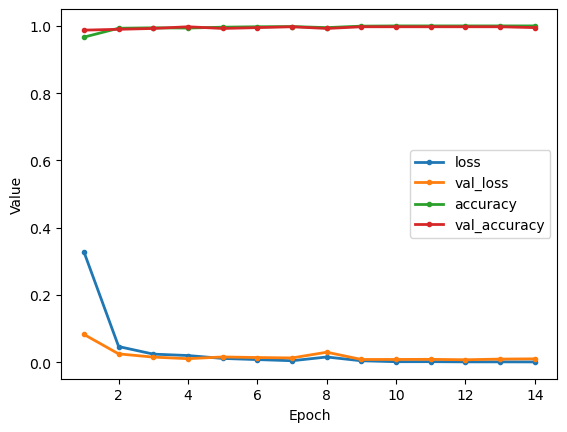

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 476us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
130,0.0,0.0,0.000000,0.0,0.0,0.0,0.003021,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1443,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1185,0.0,0.0,0.002941,0.0,0.0,0.0,0.000000,0.005882,0.0,0.002941,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1118,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.002193,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (1989, 8480)
X_test: (498, 8480)
y_train: (1989,)
y_test: (498,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,171,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,214,401 (8.45 MB)

 Trainable params: 2,214,401 (8.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 11s 477ms/step - accuracy: 0.5312 - loss: 0.6931

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5303 - loss: 0.6909   

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5571 - loss: 0.6855

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5972 - loss: 0.6775 - val_accuracy: 0.9950 - val_loss: 0.5103


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.5125

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9969 - loss: 0.4629 

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9963 - loss: 0.4085

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9961 - loss: 0.3793 - val_accuracy: 0.9925 - val_loss: 0.0609


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0465

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9993 - loss: 0.0378 

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9982 - loss: 0.0331

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9980 - loss: 0.0310 - val_accuracy: 0.9925 - val_loss: 0.0412


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0029

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 0.0021 

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0021

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0022

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0022 - val_accuracy: 0.9925 - val_loss: 0.0184


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0016

 6/25 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0032

 9/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0037

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0035

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9899 - val_loss: 0.0559


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0022

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0013 

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0012

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9925 - val_loss: 0.0363


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 3.8809e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.3789e-04 

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4636e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6176e-04 - val_accuracy: 0.9925 - val_loss: 0.0413


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.3423e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6585e-04 

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.5855e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5063e-04 - val_accuracy: 0.9925 - val_loss: 0.0444


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 3.9283e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.6601e-04 

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6017e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9053e-04 - val_accuracy: 0.9925 - val_loss: 0.0303


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 7.9348e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.1663e-04 

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.2757e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.9958e-04 - val_accuracy: 0.9925 - val_loss: 0.0483


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0015

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.9066e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 1.0000 - loss: 3.3335e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.8575e-04 - val_accuracy: 0.9899 - val_loss: 0.0723



[Train Accuracy: 100.00% - Test Accuracy: 99.40%]


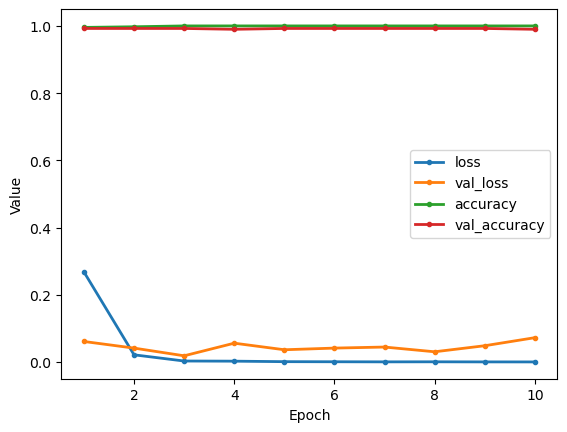

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1118,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      30,360,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,401,281 (115.97 MB)

 Trainable params: 30,401,281 (115.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 16s 681ms/step - accuracy: 0.5312 - loss: 0.6931

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.5391 - loss: 0.6930  

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5382 - loss: 0.6929

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5365 - loss: 0.6928

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5335 - loss: 0.6927

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5314 - loss: 0.6925

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5292 - loss: 0.6923

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5289 - loss: 0.6921

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.5327 - loss: 0.6918

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.5394 - loss: 0.6916

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5480 - loss: 0.6912

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5573 - loss: 0.6909

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5669 - loss: 0.6905

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5766 - loss: 0.6900

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5861 - loss: 0.6895

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5955 - loss: 0.6889

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6046 - loss: 0.6883

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6135 - loss: 0.6876

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6221 - loss: 0.6869

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6304 - loss: 0.6861

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6383 - loss: 0.6853

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6459 - loss: 0.6843

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6532 - loss: 0.6834

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6602 - loss: 0.6823

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6669 - loss: 0.6812

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - accuracy: 0.6730 - loss: 0.6802 - val_accuracy: 0.9824 - val_loss: 0.5395


Epoch 2/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9844 - loss: 0.5280

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9883 - loss: 0.5228

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.9905 - loss: 0.5191

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9919 - loss: 0.5151

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9929 - loss: 0.5111

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9936 - loss: 0.5068

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9942 - loss: 0.5021

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.9947 - loss: 0.4973

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.9951 - loss: 0.4921

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9954 - loss: 0.4869

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9957 - loss: 0.4815

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9959 - loss: 0.4762

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9959 - loss: 0.4708

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9959 - loss: 0.4653

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9959 - loss: 0.4597

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9959 - loss: 0.4541

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9960 - loss: 0.4484

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9960 - loss: 0.4426

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9960 - loss: 0.4369

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9961 - loss: 0.4313

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9961 - loss: 0.4256

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9962 - loss: 0.4200

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9962 - loss: 0.4144

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9962 - loss: 0.4090

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9963 - loss: 0.4036

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 111ms/step - accuracy: 0.9963 - loss: 0.3987 - val_accuracy: 0.9925 - val_loss: 0.0625


Epoch 3/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 1.0000 - loss: 0.0415

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0404

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0393

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 0.0380

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0368

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0356

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0344

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0334

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0325

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9998 - loss: 0.0319

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9997 - loss: 0.0312

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.9996 - loss: 0.0306

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9996 - loss: 0.0299

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9995 - loss: 0.0293

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9995 - loss: 0.0287

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9995 - loss: 0.0281

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9994 - loss: 0.0275

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9994 - loss: 0.0269

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9994 - loss: 0.0264

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9994 - loss: 0.0260

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9993 - loss: 0.0255

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9993 - loss: 0.0251

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9993 - loss: 0.0247

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9992 - loss: 0.0243

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9992 - loss: 0.0239

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.9992 - loss: 0.0236 - val_accuracy: 0.9950 - val_loss: 0.0155


Epoch 4/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0049

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0044

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0041

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0039

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0038

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0038

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0037

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0036

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0035

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0035

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0034

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0034

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0033

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 0.0033

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0032

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0032

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0032

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0031

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0031

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0031

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0030

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0030

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0030

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0029

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 0.0029

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 0.0029 - val_accuracy: 0.9925 - val_loss: 0.0175


Epoch 5/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 0.0011

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 0.0011

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0011

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0011

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0011

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0011

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0011

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 0.0011

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 0.0011

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 0.0011

11/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0010

12/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 0.0010

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0010

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0011

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0011

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 1.0000 - loss: 0.0011

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0011

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0011

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0011

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 1.0000 - loss: 0.0011

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 0.0011

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 1.0000 - loss: 0.0011

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 1.0000 - loss: 0.0011

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 0.0011

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 1.0000 - loss: 0.0011

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9925 - val_loss: 0.0169


Epoch 6/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 1.0000 - loss: 0.0013

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0012

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 0.0012

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0011

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 0.0011

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 0.0010

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 9.9863e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 9.7180e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 9.4932e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 9.2909e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 9.0918e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.9278e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.7892e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.6565e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.5470e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.4405e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.3463e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.2563e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.2300e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.1991e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.1712e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.1384e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.1012e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.0617e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.0212e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 7.9839e-04 - val_accuracy: 0.9925 - val_loss: 0.0188


Epoch 7/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 3.1981e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.3245e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.3331e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.4774e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.4918e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.5767e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.7073e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.8060e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 3.8681e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.8955e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 3.9301e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.9576e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.9846e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0016e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0159e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0253e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0300e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0360e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0374e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0378e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0343e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0313e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0265e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0241e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 4.0191e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 4.0145e-04 - val_accuracy: 0.9925 - val_loss: 0.0198


Epoch 8/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 1.0000 - loss: 3.1817e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 3.1132e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 3.0838e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 3.0088e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 2.9740e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.0602e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.0935e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.1022e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 3.1287e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.1423e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.1438e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 3.1437e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 3.1564e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.2191e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 1.0000 - loss: 3.2689e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3068e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.3734e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 3.4240e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.4631e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.4937e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 3.5200e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5416e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5617e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5783e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 3.5900e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 3.6009e-04 - val_accuracy: 0.9925 - val_loss: 0.0159


Epoch 9/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 1.0000 - loss: 2.7935e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.6063e-04 

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.4239e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.3211e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.2867e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 2.2532e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 2.2545e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 2.2621e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 2.2536e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.2585e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.2585e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.2600e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.2641e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.2676e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.2723e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.2730e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.2853e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.2927e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.2997e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.3074e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.3139e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.3180e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.3203e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.3238e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 2.3251e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 2.3263e-04 - val_accuracy: 0.9925 - val_loss: 0.0175


Epoch 10/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 1.2279e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 1.3390e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 1.3043e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 1.3437e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.3677e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.3791e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.3882e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 1.0000 - loss: 1.4029e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 1.0000 - loss: 1.4142e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 1.4202e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 1.4240e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 1.4314e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 1.4410e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.4688e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.4946e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.5147e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.5310e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.5457e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.5580e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.5691e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.5784e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.5920e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.6167e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.6382e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 1.6575e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 1.6753e-04 - val_accuracy: 0.9925 - val_loss: 0.0205


Epoch 11/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 1.0000 - loss: 1.1507e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 1.0662e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.0909e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 1.1458e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 1.1820e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.2016e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.2148e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.2327e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 1.0000 - loss: 1.2506e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.2787e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3004e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3132e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3199e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3270e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3314e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3372e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3403e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3456e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3485e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3516e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3529e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3523e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3507e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3486e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 1.0000 - loss: 1.3455e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 1.0000 - loss: 1.3427e-04 - val_accuracy: 0.9925 - val_loss: 0.0237


Epoch 12/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 7.0812e-05

 2/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 7.5376e-05

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 7.6084e-05

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 8.0711e-05

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 8.3203e-05

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 8.4720e-05

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 8.6230e-05

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 1.0000 - loss: 8.7366e-05

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 1.0000 - loss: 8.7858e-05

10/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.7967e-05

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 8.8147e-05

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 8.8284e-05

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 1.0000 - loss: 8.8348e-05

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.8272e-05

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.8316e-05

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.8411e-05

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.8327e-05

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.8249e-05

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.8336e-05

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.8451e-05

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.9013e-05

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 8.9590e-05

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 9.0811e-05

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 9.1894e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 1.0000 - loss: 9.2913e-05

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 1.0000 - loss: 9.3853e-05 - val_accuracy: 0.9925 - val_loss: 0.0233


Epoch 13/100


 1/25 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 1.0000 - loss: 1.9716e-04

 2/25 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 1.0000 - loss: 1.5869e-04

 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 1.0000 - loss: 1.3673e-04

 4/25 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 1.0000 - loss: 1.2169e-04

 5/25 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 1.0000 - loss: 1.1562e-04

 6/25 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 1.0000 - loss: 1.1161e-04

 7/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0792e-04

 8/25 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 1.0000 - loss: 1.0686e-04

 9/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.0573e-04

10/25 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 1.0000 - loss: 1.0509e-04

11/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.0430e-04

12/25 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 1.0000 - loss: 1.0380e-04

13/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0334e-04

14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0276e-04

15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.0255e-04

16/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.0267e-04

17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.0272e-04

18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.0257e-04

19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 1.0000 - loss: 1.0232e-04

20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0197e-04

21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 1.0152e-04

22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.0113e-04

23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.0079e-04

24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.0064e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 1.0000 - loss: 1.0045e-04

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 1.0000 - loss: 1.0027e-04 - val_accuracy: 0.9925 - val_loss: 0.0204



[Train Accuracy: 100.00% - Test Accuracy: 99.80%]


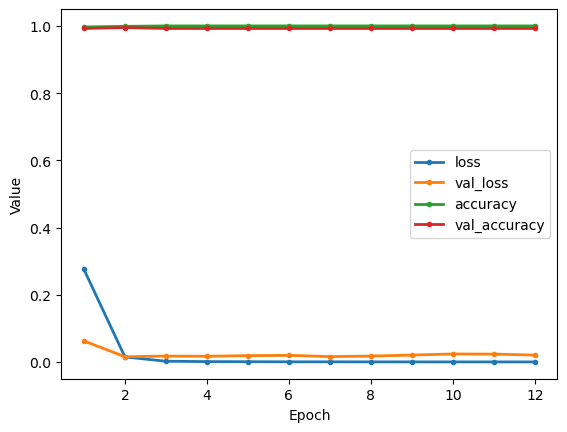

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


 1/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

 8/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [25]:
report.save()

Report saved as Output/Reports/BBR-BPC/report_3VTR4RT4.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################